In [1]:
import xarray as xr
import numpy as np 
import os
import types
import matplotlib.pyplot as plt
import pandas as pd

from src.utils import util_cesm
from src import config_cesm
from src.models import models_util

reference_grid = util_cesm.generate_sps_grid()

def load_globals(module):
    """
    Load all global variables declared in a module as a dictionary.
    
    Parameters:
        module (module): The loaded Python module.
    
    Returns:
        dict: A dictionary containing global variables from the module.
    """
    return {
        name: value
        for name, value in vars(module).items()
        if not name.startswith("__") and not isinstance(value, types.ModuleType) and not callable(value)
    }

def get_ensemble_members_and_time_coords(data_split_settings, split):
    if data_split_settings["split_by"] == "ensemble_member":
        ensemble_members = data_split_settings[split]
        time_coords = data_split_settings["time_range"]
    elif data_split_settings["split_by"] == "time":
        ensemble_members = data_split_settings["member_ids"]
        time_coords = data_split_settings[split]

    return ensemble_members, time_coords


def broadcast_climatology_like(data_split_settings, da):
    """
    Param:
        dict            this should have the name of the data_settings which specifies the climatology 
        xr.DataArray    prediction-like array that you want to broadcast climatology 
    
    Returns:
        xr.DataArray    climatology broadcasted
    """

    icefrac_mean = xr.open_dataset(f"{config_cesm.PROCESSED_DATA_DIRECTORY}/normalized_inputs/{data_split_settings["name"]}/icefrac_mean.nc").icefrac
    
    def calculate_month(start_month, lead_time):
        return (start_month + lead_time - 2) % 12 + 1

    pred_months = xr.apply_ufunc(
        calculate_month,
        da["start_prediction_month"].dt.month,
        da["lead_time"],
        vectorize=True,
        dask="allowed",
        output_dtypes=[int],
    )

    climatology_broadcasted = icefrac_mean.sel(month=pred_months).broadcast_like(da).drop_vars("month")

    return climatology_broadcasted


def add_climatology(da, climatology_broadcasted, clip=True):
    """
    Param:
        (xr.DataArray)  array of anomalies
        (xr.DataArray)  array of climatology that is the same shape as da
                        note: to do this you can run broadcast_climatology_like
        (bool)          possibly clip the anomalies to 

    Returns:
        (xr.DataArray)
    """
    # Add climatology back to the anomalies
    absolute_da = da + climatology_broadcasted

    # Clip the resulting values to [0, 1]
    if clip: absolute_da = absolute_da.clip(0, 1)

    return absolute_da

def remove_climatology(da, climatology_broadcasted):
    return da - climatology_broadcasted


def load_model_predictions(config, nn_ens_avg=True, climatology_broadcasted=None, add_climatology_to_anomaly=True):
    """
    If the config specifies that the predictions are anomalies, then the climatology is added back
    WITH clipping of unphysical values (e.g., if anomaly prediction is -0.5 but the climatology for that
    cell is 0.3, then the resulting value will be clipped to 0).
    """
    output_dir = os.path.join(config_cesm.PREDICTIONS_DIRECTORY, config["EXPERIMENT_NAME"])
    output_path = os.path.join(output_dir, f"{config["MODEL"]}_{config["CHECKPOINT_TO_EVALUATE"]}_predictions.nc")
    predictions = xr.open_dataset(output_path).predictions 

    if config["TARGET_CONFIG"]["predict_anom"] and add_climatology_to_anomaly:
        if climatology_broadcasted is None:
            raise ValueError("need to supply climatology_broadcasted if add_climatology_to_anomaly is true!")

        predictions = add_climatology(predictions, climatology_broadcasted)

    if nn_ens_avg and ("nn_member_id" in predictions.dims): 
        predictions = predictions.mean("nn_member_id")

    return predictions 

def load_targets(config, split, climatology_broadcasted=None, add_climatology_to_anomaly=True):
    ensemble_members, time_coords = get_ensemble_members_and_time_coords(config["DATA_SPLIT_SETTINGS"], split)
    data_dir = os.path.join(config_cesm.PROCESSED_DATA_DIRECTORY, "data_pairs", config["DATA_SPLIT_SETTINGS"]["name"])
    ds_list = []
    for member_id in ensemble_members:
        ds = xr.open_dataset(os.path.join(data_dir, f"targets_member_{member_id}.nc")).data.load()
        ds_list.append(ds)

    targets = xr.concat(ds_list, dim="member_id").sel(start_prediction_month=time_coords)
    targets = targets.transpose("start_prediction_month", "member_id", "lead_time", "y", "x")

    if config["TARGET_CONFIG"]["predict_anom"] and add_climatology_to_anomaly:
        if climatology_broadcasted is None:
            raise ValueError("need to supply climatology_broadcasted if add_climatology_to_anomaly is true!")

        targets = add_climatology(targets, climatology_broadcasted)

    return targets

def get_broadcast_climatology(config, split):
    ensemble_members, time_coords = get_ensemble_members_and_time_coords(config["DATA_SPLIT_SETTINGS"], split)

    empty_predictions_da = models_util.generate_empty_predictions_ds(reference_grid, 
            time_coords, 
            ensemble_members,
            config["MAX_LEAD_MONTHS"], 80, 80).predictions 
    
    return broadcast_climatology_like(config["DATA_SPLIT_SETTINGS"], empty_predictions_da)

def calculate_acc(pred_anom, truth_anom, aggregate, dim="start_prediction_month"):
    """
    Calculate the Anomaly Correlation Coefficient (ACC) between predictions and truth.

    Parameters:
    - pred_anom  (xr.DataArray): Predictions (absolute, not anomalies) 
    - truth_anom (xr.DataArray): True anomalies with dimensions including `dim`.
    - aggregate          (bool): if True, mean-aggregate down to dims (month, lead_time) 
    - dim                 (str): The dimension over which to calculate the ACC.
                                 Default is "start_prediction_month".
    
    Returns:
    - xr.DataArray: ACC values with dimensions remaining after collapsing `dim`.
    """
    # Ensure dimensions match
    if pred_anom.dims != truth_anom.dims:
        raise ValueError("Predictions and truth must have the same dimensions.")

    acc = xr.cov(pred_anom, truth_anom, dim=dim) / (pred_anom.std(dim=dim) * truth_anom.std(dim=dim))

    if aggregate:
        if dim == ("x", "y"):
            acc = acc.mean('member_id').groupby("start_prediction_month.month").mean("start_prediction_month")
            
        # roll in lead time so that it gets lined up
        acc = xr.concat(
            [acc.roll(month=int(lt - 1), roll_coords=False).sel(lead_time=lt) for lt in acc.lead_time.values],
            dim="lead_time"
        )

    return acc

class ModelDiagnostics():
    """
    This wrapper class is used to evaluate the model predictions for a given experiment configuration.
    """

    def __init__(self, config, nn_ens_avg, climatology_broadcasted: xr.DataArray = None):
        """
        Expected: 
            config (dict)       dictionary of the experiment configuration 
            nn_ens_avg (bool)   if the predictions include multiple neural net ensemble members, 
                                this averages the predictions if set to true. 

        Optional:
            climatology_broadcasted (xr.DataArray)  climatology broadcasted to the same shape \
                as the model predictions. If not provided, then it will be loaded according to \
                config. Note that this can take a long time, so if possible it is preferable \
                to supply the climatology_broadcasted array.
        """

        self.config = config
        self.nn_ens_avg = nn_ens_avg 

        # load climatology if not provided
        if climatology_broadcasted is None:
            self.climatology_broadcasted = get_broadcast_climatology(config, "test")
        else:
            self.climatology_broadcasted = climatology_broadcasted

        # load predictions and targets into xr.DataArray 
        self.predictions = self.load_model_predictions_wrapper()
        self.predictions_anomaly = remove_climatology(self.predictions, self.climatology_broadcasted)

        self.targets = self.load_targets_wrapper()
        self.targets_anomaly = remove_climatology(self.targets, self.climatology_broadcasted)

        # calculate linear difference
        self.diff = self.predictions - self.targets
        
    def load_model_predictions_wrapper(self):
        return load_model_predictions(self.config, self.nn_ens_avg, climatology_broadcasted=self.climatology_broadcasted) 

    def load_targets_wrapper(self):
        return load_targets(self.config, "test", climatology_broadcasted=self.climatology_broadcasted)

    def calculate_acc(self, aggregate, dim):
        return calculate_acc(self.predictions_anomaly, self.targets_anomaly, aggregate, dim)

In [22]:
import xarray as xr
import numpy as np
import pyproj 

ds = xr.open_dataset("/scratch/users/yucli/cesm_data_processed/normalized_inputs/seaice_plus_auxiliary/icefrac_norm.nc")
mean = xr.open_dataset("/scratch/users/yucli/cesm_data_processed/normalized_inputs/seaice_plus_auxiliary/icefrac_mean.nc")
grid = xr.open_dataset("/oak/stanford/groups/earlew/yuchen/cesm_data/grids/80x80_SPS_grid.nc")


In [24]:
def generate_sps_grid(grid_size=80, lat_boundary=-52.5):
    # Define the South Polar Stereographic projection (EPSG:3031)
    proj_south_pole = pyproj.Proj(proj='stere', lat_0=-90, lon_0=0, lat_ts=-70)

    # Define the geographic coordinate system (EPSG:4326)
    proj_geographic = pyproj.Proj(proj='latlong', datum='WGS84')

    # Create a transformer object for forward (Stereographic to Geographic) transformations
    transformer = pyproj.Transformer.from_proj(proj_south_pole, proj_geographic, always_xy=True)

    # Compute the maximum radius from the South Pole in stereographic coordinates
    _, max_radius = proj_south_pole(0, lat_boundary)

    x = np.linspace(-max_radius, max_radius, grid_size)
    y = np.linspace(-max_radius, max_radius, grid_size)
    X, Y = np.meshgrid(x, y)

    # Transform coordinates to geographic (lat, lon) for the cell centers
    lon, lat = transformer.transform(X, Y)

    # Compute the edges (boundaries) of the grid cells
    x_edges = np.linspace(-max_radius, max_radius, grid_size + 1)
    y_edges = np.linspace(-max_radius, max_radius, grid_size + 1)
    X_edges, Y_edges = np.meshgrid(x_edges, y_edges)

    # Transform the edges to geographic coordinates
    lon_edges, lat_edges = transformer.transform(X_edges, Y_edges)

    # Calculate grid cell areas
    geod = pyproj.Geod(ellps="WGS84")
    areas = np.zeros((grid_size, grid_size))

    for i in range(grid_size):
        for j in range(grid_size):
            # Define the four corners of the grid cell using edges
            lons = [lon_edges[i, j], lon_edges[i + 1, j], lon_edges[i + 1, j + 1], lon_edges[i, j + 1]]
            lats = [lat_edges[i, j], lat_edges[i + 1, j], lat_edges[i + 1, j + 1], lat_edges[i, j + 1]]
            
            # Compute the polygon area
            area, _ = geod.polygon_area_perimeter(lons, lats)
            areas[i, j] = abs(area)  # Area might be negative due to polygon orientation

    # Create the output dataset
    output_grid = xr.Dataset(
        {
            "lat": (["y", "x"], lat),
            "lon": (["y", "x"], lon),
            "area": (["y", "x"], areas),
        },
        coords={
            "x": (["x"], x),
            "y": (["y"], y),
        }
    )

    return output_grid


def calculate_area_weights():
    """
    Calculates a grid of weights according to grid cell area 

    Returns:
        (np.array)      weights (shape=(80,80))
    """

    grid = generate_sps_grid()
    
    weights = (grid.area / np.mean(grid.area)).values 

    return weights 

grid = generate_sps_grid()


In [32]:
weights = (ds["icefrac"] ** 2).groupby("time.month").mean(("time", "member_id", "x", "y"))
weights = (1/weights)
weights = weights / weights.mean()

In [37]:
weights.data

array([1.030789  , 1.3560966 , 1.1643478 , 1.0760003 , 0.9710066 ,
       0.9211758 , 0.942355  , 0.9647882 , 0.93632054, 0.9055688 ,
       0.854506  , 0.877045  ], dtype=float32)

## Some SST files are corrupted
Ensemble members 'r2i1231p1f1', 'r4i1231p1f1', 'r5i1231p1f1', 'r6i1231p1f1', 'r7i1231p1f1' have all NaN SST for some times

In [9]:
from src.experiment_configs.exp1_inputs import input2 
from src.experiment_configs.exp1_inputs import input3a
from src.experiment_configs.exp1_inputs import input3b
from src.experiment_configs.exp1_inputs import input3c
from src.experiment_configs.exp1_inputs import input4 

cdicts = {
    # "input2": input2, 
    "input3a": input3a, 
    # "input3b": input3b, 
    # "input3c": input3c, 
    # "input4": input4
}

input_da = {}

for name, cdict in cdicts.items():
    print(f"checking for 0 values in {name}")
    cdict = load_globals(cdict) 
    dir = f"/scratch/users/yucli/cesm_data_processed/data_pairs/{cdict["DATA_CONFIG_NAME"]}/"
    da_list = []
    for f in os.listdir(dir):
        if "inputs" in f:
            da = xr.open_dataset(os.path.join(dir, f)).data
            for k, channel in enumerate(da.channel):
                if np.any((da.isel(channel=k).mean(("x","y"))) == 0):
                    print(f"found a data point of all 0s in {channel.values} in {f}")
            
da

checking for 0 values in input3a
found a data point of all 0s in temp_lag6 in inputs_member_r2i1231p1f1.nc
found a data point of all 0s in temp_lag5 in inputs_member_r2i1231p1f1.nc
found a data point of all 0s in temp_lag4 in inputs_member_r2i1231p1f1.nc
found a data point of all 0s in temp_lag3 in inputs_member_r2i1231p1f1.nc
found a data point of all 0s in temp_lag2 in inputs_member_r2i1231p1f1.nc
found a data point of all 0s in temp_lag1 in inputs_member_r2i1231p1f1.nc


<xarray.DataArray 'data' (start_prediction_month: 1956, channel: 21, y: 80,
                          x: 80)> Size: 2GB
[262886400 values with dtype=float64]
Coordinates:
  * y                       (y) float64 640B -4.208e+06 -4.101e+06 ... 4.208e+06
  * x                       (x) float64 640B -4.208e+06 -4.101e+06 ... 4.208e+06
    member_id               <U12 48B ...
  * channel                 (channel) <U20 2kB 'icefrac_lag12' ... 'land_mask'
  * start_prediction_month  (start_prediction_month) datetime64[ns] 16kB 1851...
    z_t                     float32 4B ...

In [13]:
da_sst = xr.open_dataset(f"{config_cesm.RAW_DATA_DIRECTORY}/temp_combined.nc").temp
nan_mask = np.isnan(da_sst.mean(("x","y")))

In [19]:
nan_mask.member_id[nan_mask.sum("time") != 0]

<xarray.DataArray 'member_id' (member_id: 5)> Size: 240B
array(['r2i1231p1f1', 'r4i1231p1f1', 'r5i1231p1f1', 'r6i1231p1f1',
       'r7i1231p1f1'], dtype='<U12')
Coordinates:
  * member_id  (member_id) <U12 240B 'r2i1231p1f1' ... 'r7i1231p1f1'
    z_t        float32 4B ...

# Data normalization tests

In [127]:
data_dir = "/scratch/users/yucli/cesm_data_processed/normalized_inputs/seaice_plus_sst/"
temp_da = xr.open_dataset(os.path.join(data_dir, "temp_norm.nc")).temp
median_temp_norm = np.nanmedian(np.abs(temp_da))

data_dir = "/scratch/users/yucli/cesm_data_processed/normalized_inputs/seaice_plus_sst_minmax/"
temp_da_minmax = xr.open_dataset(os.path.join(data_dir, "temp_norm.nc")).temp
median_temp_norm_minmax = np.nanmedian(np.abs(temp_da_minmax))


In [132]:
print(np.sum(temp_da_minmax > median_temp_norm_minmax * 10))
print(np.sum(temp_da > median_temp_norm * 10))

<xarray.DataArray 'temp' ()> Size: 8B
array(55)
Coordinates:
    z_t      float32 4B ...
<xarray.DataArray 'temp' ()> Size: 8B
array(29729)
Coordinates:
    z_t      float32 4B ...


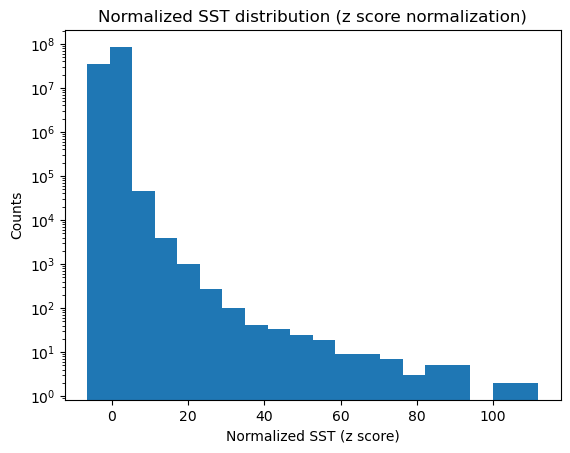

In [141]:
plt.hist(temp_da.to_numpy().flatten(), bins=20)
plt.yscale("log")
plt.ylabel("Counts")
plt.xlabel("Normalized SST (z score)")
plt.title("Normalized SST distribution (z score normalization)")
plt.savefig("figures/known_issues/sst_poor_normalization_hist.jpg", dpi=300, bbox_inches='tight')

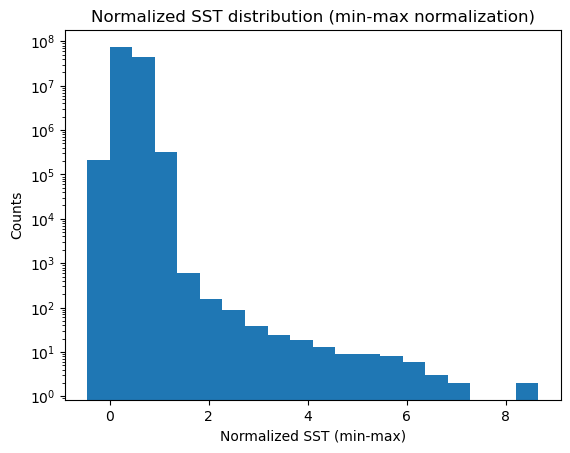

In [142]:
plt.hist(temp_da_minmax.to_numpy().flatten(), bins=20)
plt.yscale("log")
plt.ylabel("Counts")
plt.xlabel("Normalized SST (min-max)")
plt.title("Normalized SST distribution (min-max normalization)")
plt.savefig("figures/known_issues/sst_minmax_normalization_hist.jpg", dpi=300, bbox_inches='tight')

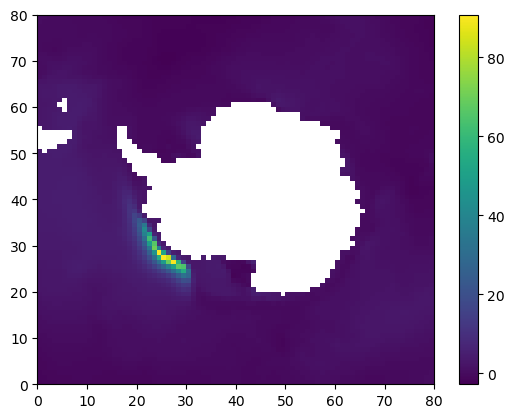

In [165]:
plt.pcolormesh(temp_da.isel(member_id=11, time=1324))
plt.colorbar()
plt.savefig("figures/known_issues/sst_poor_normalization_map_cesm.jpg", dpi=300)

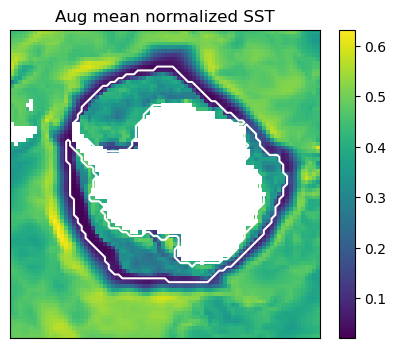

In [116]:
plt.figure(figsize=(5,4))
plt.contour(icefrac_mean.isel(month=7) > 0.85, colors='w')
plt.pcolormesh((temp_norm_avg).isel(month=7))
plt.xticks([])
plt.yticks([])
plt.title("Aug mean normalized SST")
plt.colorbar()
plt.savefig("figures/known_issues/sst_minmax_mean_example.jpg", dpi=300, bbox_inches='tight')

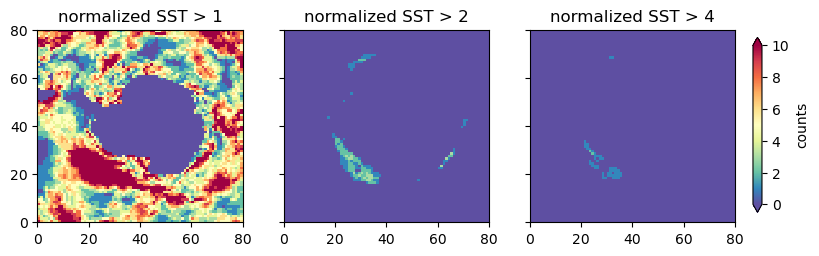

In [70]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(9,2.5), sharex=True, sharey=True) 

for i, thresh in enumerate([1, 2, 4]):
    cax = axs[i].pcolormesh((ds.temp > thresh).sum(("time", "member_id")), vmin=0, vmax=10, cmap="Spectral_r")
    axs[i].set_title(f"normalized SST > {thresh}")

cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7]) 
cbar = fig.colorbar(cax, cax=cbar_ax, orientation='vertical', extend='both', label="counts")
plt.savefig("figures/known_issues/sst_minmax_norm.jpg", dpi=300, bbox_inches='tight')

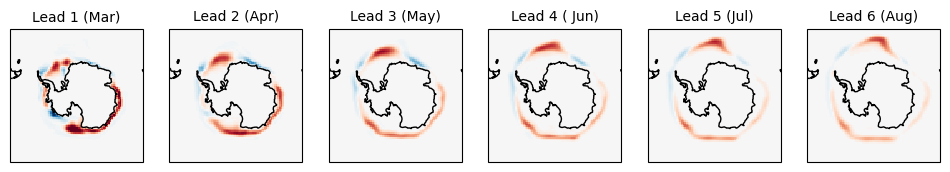

In [38]:
import cartopy.crs as ccrs

ds = xr.open_dataset("/scratch/users/yucli/sicpred_model_predictions/exp2_vol4/UNetRes3_epoch_10_predictions.nc")

fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(12,2), subplot_kw={'projection': ccrs.SouthPolarStereo()})

months = {1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: " Jun", 
            7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"}

for i in range(6):
    t = 110
    axs[i].pcolormesh(reference_grid.lon,
                    reference_grid.lat, 
                    ds.predictions.isel(start_prediction_month=t, lead_time=i, member_id=0, nn_member_id=0),
                    transform=ccrs.PlateCarree(),
                    cmap="RdBu_r",
                    vmin=-0.4, vmax=0.4)
    month = ds.start_prediction_month[t+i].dt.month.data
    axs[i].set_title(f"Lead {i+1} ({months[int(month)]})", fontsize=10)
    axs[i].coastlines()

#plt.savefig("figures/illustrations/cesm_example_prediction.jpg", dpi=300, bbox_inches="tight")

In [22]:
import gc

from src.experiment_configs.tests import regularization_plus_minmax_norm
from src.experiment_configs.tests import minmax_norm_noreg 

cdicts = {
    "input2": input2,
    "input3_outlier": input3,
    "input3_reg": regularization_plus_minmax_norm,
    "input3_noreg": minmax_norm_noreg
}

acc = {}

num_nn_ens_members = {
    "input2": 5, "input3_outlier": 5, "input3_noreg": 1, "input3_reg": 1
}

for key, config in cdicts.items(): 
    print(f"Calculating ACC for {key}")
    cdict = load_globals(config)
    diagnostics_full = ModelDiagnostics(cdict, False, climatology_broadcast) 
    
    # calculate acc for each member separately 
    acc_temp_list = []
    for i in range(num_nn_ens_members[key]): 
        acc_temp = calculate_acc(diagnostics_full.predictions_anomaly.isel(nn_member_id=i), 
                            diagnostics_full.targets_anomaly, 
                            dim=("x","y"), aggregate=True)
        acc_temp_list.append(acc_temp)
    acc[key] = xr.concat(acc_temp_list, dim="nn_member_id")

    del diagnostics_full, acc_temp_list, acc_temp
    gc.collect()



Calculating ACC for input2
Calculating ACC for input3_outlier
Calculating ACC for input3_reg
Calculating ACC for input3_noreg


Note: `input3_noreg` is a configuration trained on min-max normalized data

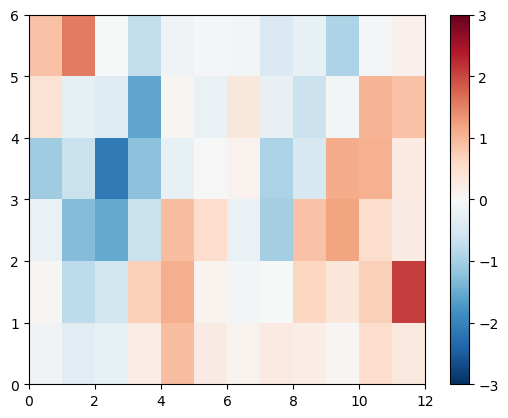

In [37]:
avg_acc_diff = (acc["input2"] - acc["input3_noreg"].isel(nn_member_id=0)).mean("nn_member_id")
plt.pcolormesh(avg_acc_diff * 100, vmin=-3, vmax=3, cmap="RdBu_r")
plt.colorbar()

## trends in inputs

In [2]:
data_dir = "/scratch/users/yucli/cesm_data_processed/normalized_inputs/seaice_plus_sst"
ds = xr.open_dataset(os.path.join(data_dir, "icefrac_norm.nc"))

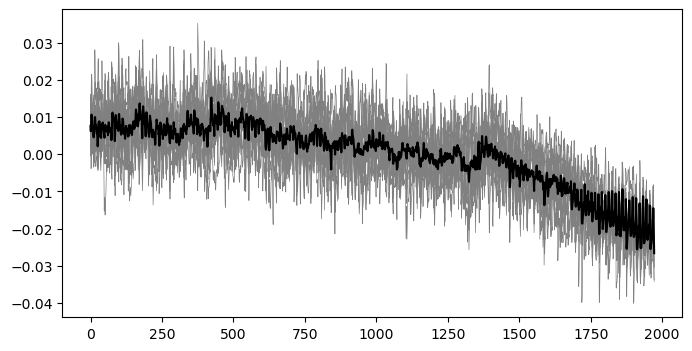

In [3]:
plt.figure(figsize=(8,4))
for i in range(len(ds.member_id)):
    plt.plot(ds.icefrac.isel(member_id=i).mean(("x","y")), color='grey', linewidth=0.5)
plt.plot(ds.icefrac.mean(("x","y","member_id")), color='k')

In [97]:
from src.experiment_configs.exp1_inputs import input2
input2_cdict = load_globals(input2)

# detrended predictions and targets
path_dt = "/scratch/users/yucli/sicpred_model_predictions/exp1_input2_dt"
pred_dt = xr.open_dataset(os.path.join(path_dt, "UNetRes3_epoch_10_predictions.nc")).predictions

targets_dt = load_targets(input2_cdict, "test", add_climatology_to_anomaly=False)

path = "/scratch/users/yucli/sicpred_model_predictions/exp1_input2"
pred = xr.open_dataset(os.path.join(path, "UNetRes3_epoch_10_predictions.nc")).predictions

# note: this is really bad organization but I overwrote the input2 data pairs when preprocessing
# so there no longer exists the non-detrended data pairs. However, since the targets for the 
# exp1 are all the same, I will use the non-detrended input3 as a surrogate 
ensemble_members, time_coords = get_ensemble_members_and_time_coords(input2_cdict["DATA_SPLIT_SETTINGS"], "test")

data_dir = os.path.join(config_cesm.PROCESSED_DATA_DIRECTORY, "data_pairs/seaice_plus_psl")
ds_list = []
for member_id in ensemble_members:
    ds = xr.open_dataset(os.path.join(data_dir, f"targets_member_{member_id}.nc")).data.load()
    ds_list.append(ds)

targets = xr.concat(ds_list, dim="member_id").sel(start_prediction_month=time_coords)
targets = targets.transpose("start_prediction_month", "member_id", "lead_time", "y", "x")


In [7]:
acc_temp_list = []
acc_temp_list2 = []
for i in range(5): 
    acc_temp = calculate_acc(pred.isel(nn_member_id=i), targets, dim=("x","y"), aggregate=False)
    acc_temp_dt = calculate_acc(pred_dt.isel(nn_member_id=i), targets_dt, 
                        dim=("x","y"), aggregate=False)
    acc_temp_list.append(acc_temp.mean("member_id"))
    acc_temp_list2.append(acc_temp_dt.mean("member_id"))

acc_dt = xr.concat(acc_temp_list2, dim="nn_member_id")
acc = xr.concat(acc_temp_list, dim="nn_member_id")


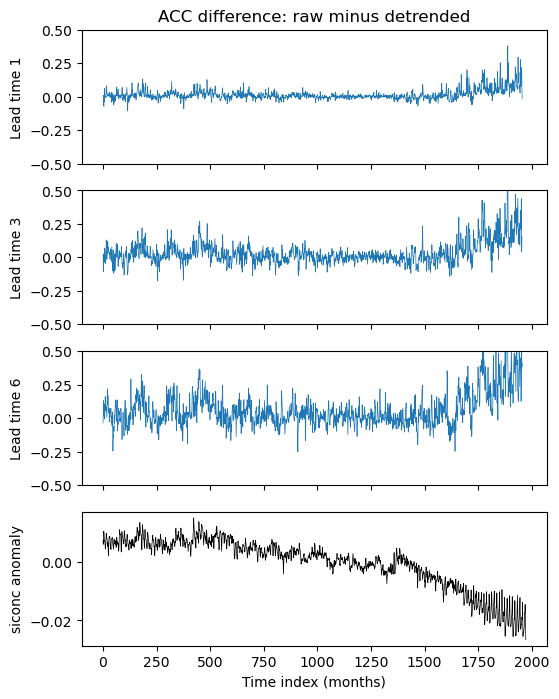

In [81]:
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(6,8), sharex=True)


for i, lead in enumerate([1, 3, 6]):
    axs[i].plot((acc.sel(lead_time=lead) - acc_dt.sel(lead_time=lead)).mean("nn_member_id"), 
                linewidth=0.5)
    axs[i].set_ylim([-0.5, 0.5])
    axs[i].set_ylabel(f"Lead time {lead}")

axs[0].set_title("ACC difference: raw minus detrended")
axs[3].plot(ds.icefrac.mean(("x","y","member_id")), color='k', linewidth=0.5)
axs[3].set_ylabel("siconc anomaly")
axs[3].set_xlabel("Time index (months)")
plt.savefig("figures/known_issues/detrended_versus_raw_performance.jpg", dpi=300, bbox_inches='tight')

In [85]:
coeffs = xr.open_dataset("/scratch/users/yucli/cesm_data_processed/normalized_inputs/seaice_plus_auxiliary/icefrac_detrend_coeffs.nc")

def evaluate_quadratic_trend(coeff_da, time_coord):
    """
    Evaluate a quadratic trend given coefficients and a time coordinate.
    
    coeff_da: DataArray with dims ('month', 'coeff', ...) where coeff = [const, linear, quadratic]
    time_coord: xarray coordinate of shape (T,) — must be datetime64
    
    Returns: DataArray of shape (T, *spatial_dims)
    """
    t = time_coord.dt.year + time_coord.dt.month / 12.0
    month = time_coord.dt.month

    const = coeff_da.sel(coeff='const').sel(month=month)
    linear = coeff_da.sel(coeff='linear').sel(month=month)
    quad = coeff_da.sel(coeff='quadratic').sel(month=month)

    trend = const + linear * t + quad * t**2
    return trend

trend = evaluate_quadratic_trend(coeffs, pred_dt.start_prediction_month).icefrac

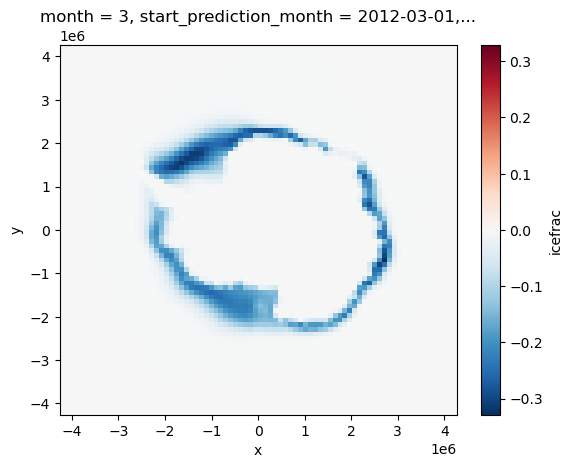

In [105]:
trend.isel(start_prediction_month=1929 + 5).plot()

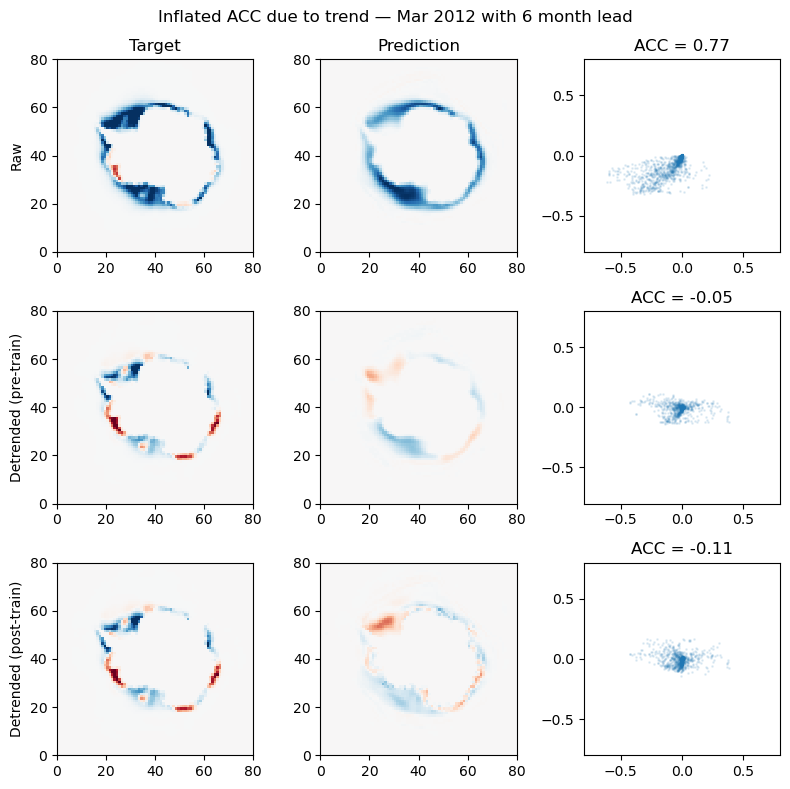

In [108]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(8,8)) 

targets_list = [targets, targets_dt]
preds_list = [pred, pred_dt] 
for i, p in enumerate(preds_list):
    t = targets_list[i].isel(member_id=0, start_prediction_month=1929, lead_time=5)
    p = p.isel(member_id=0, start_prediction_month=1929, lead_time=5).mean("nn_member_id")
    axs[i, 0].pcolormesh(t, vmin=-0.3, vmax=0.3, cmap="RdBu_r")
    axs[i, 1].pcolormesh(p, vmin=-0.3, vmax=0.3, cmap="RdBu_r")
    axs[i, 2].scatter(t.to_numpy().flatten(), p.to_numpy().flatten(), alpha=0.1, s=1)
    axs[i, 2].set_ylim([-0.8,0.8])
    axs[i, 2].set_xlim([-0.8,0.8])

    # subtract trend from the non-detrended prediction
    if i == 0:
        t_dt = t - trend.isel(start_prediction_month=1929 + 5)
        p_dt = p - trend.isel(start_prediction_month=1929 + 5)
        axs[2, 0].pcolormesh(t_dt, vmin=-0.3, vmax=0.3, cmap="RdBu_r")
        axs[2, 1].pcolormesh(p_dt, vmin=-0.3, vmax=0.3, cmap="RdBu_r")
        axs[2, 2].scatter(t_dt.to_numpy().flatten(), p_dt.to_numpy().flatten(), alpha=0.1, s=1)
        axs[2, 2].set_ylim([-0.8,0.8])
        axs[2, 2].set_xlim([-0.8,0.8])
        acc_sample = np.corrcoef(t_dt.to_numpy().flatten(), p_dt.to_numpy().flatten())
        axs[2, 2].set_title(f"ACC = {round(acc_sample[1,0], 2)}")

    acc_sample = np.corrcoef(t.to_numpy().flatten(), p.to_numpy().flatten())
    axs[i, 2].set_title(f"ACC = {round(acc_sample[1,0], 2)}")

axs[0, 0].set_title("Target")
axs[0, 1].set_title("Prediction")
axs[0, 0].set_ylabel("Raw")
axs[1, 0].set_ylabel("Detrended (pre-train)")
axs[2, 0].set_ylabel("Detrended (post-train)")

plt.suptitle("Inflated ACC due to trend — Mar 2012 with 6 month lead")
plt.tight_layout()
plt.savefig("figures/known_issues/detrended_versus_raw_example.jpg", dpi=300, bbox_inches='tight')
# targets_dt.isel(member_id=0, start_prediction_month=1929, lead_time=5).plot()
# plt.show()
# targets.isel(member_id=0, start_prediction_month=1929, lead_time=5).plot()